# Model building

## Needed Theory
As explained before, we'll train a neural network to learn an embeddings space to represent images so that after we can use it to compare two input images $=>$ more formally a siamese network, with that saying what we 're going to do is use a pretrained model including the early layers and maybe exclude some of the last layers.

For the sake of simplicity here's an example of the architecture: 

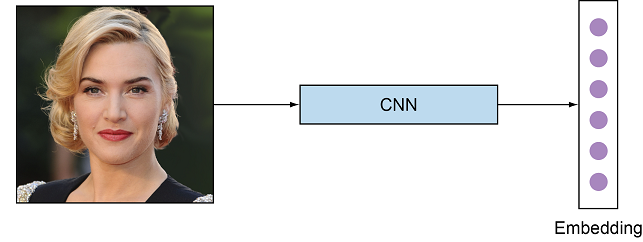

The embeddings can be seen as a vector space, and so our goal here is to change the images representation so that similar images have close representation here's what that looks like visually: 

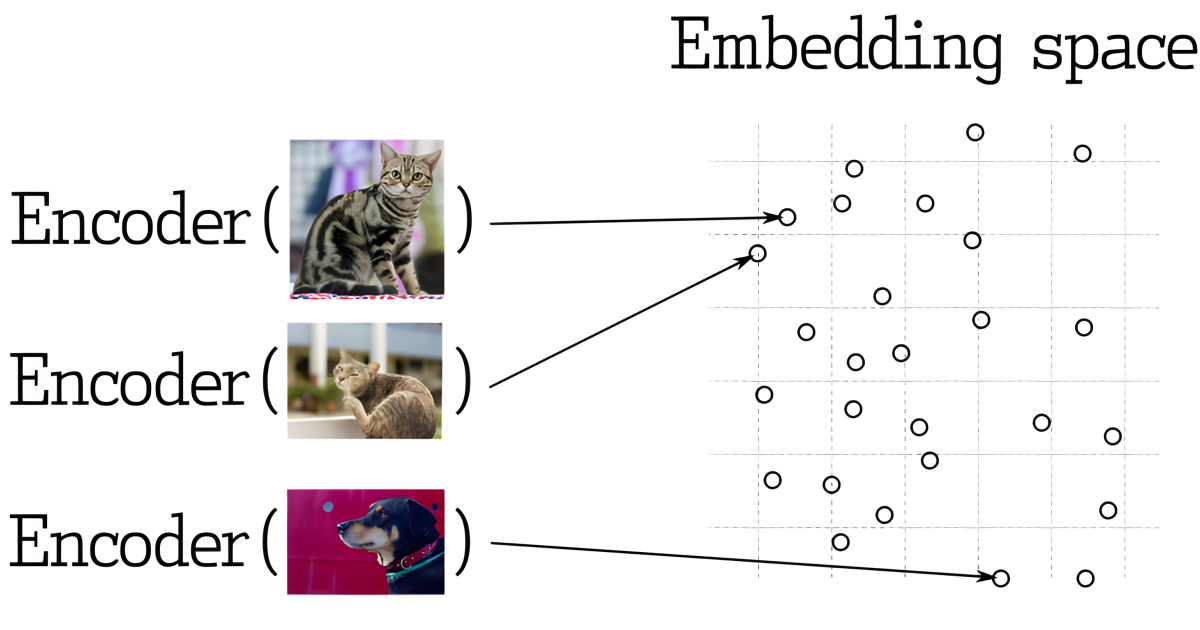


### Similarity Formalism
So far researchers have defined similarity differently, the one we'll use for this notebook is this intuitive one, $P(Img_1 = Img_2)$ : Probability of a the first image being the same as the second, this might make your brain click since you already know the sigmoid activation function, here's how the model in this case is going to work:

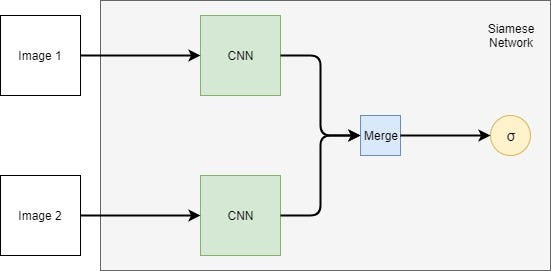

- Note that there are other several ways to formalize similarity that maybe we can use in this notebook such the cosine similarity and the euclidean distance.

### Transfer Learning 
As an inspiration from the cited ressources, We'll use the pretrained VGG16 model, at first glance this might seem contraversal and question like this might click on your head: Why the need of such a big model while we 've got such a huge dataset of 13k images of 5k people, well it's all about the context we're working on, in fact we've got a limited number of images of the same person as we said earlier we're hoping to fight the One-shot learning problem.
here's how we 're going to tackle the problem seeking a high accuracy score:

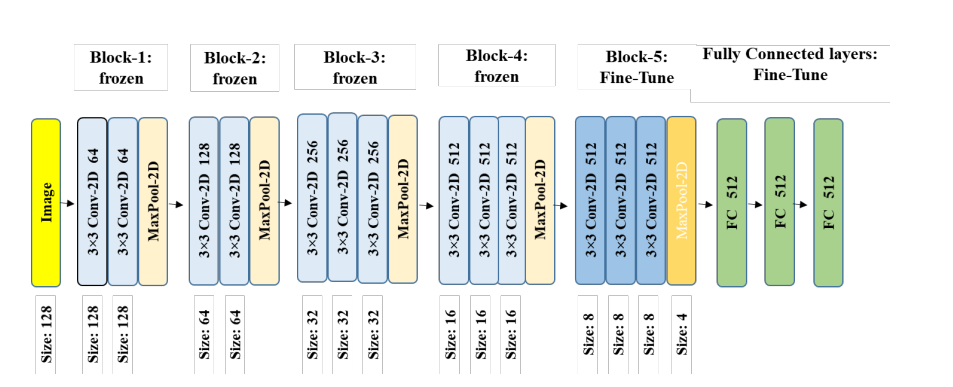

### Preprocessing
Note that the use of VGG16 network implies the need of having images with size $224 \times 244$. We'll explore and preprocess data so that can be used.
The dataset provides two recommended configurations for developing training and testing sets: pairs or people. Since our goal is to predict similarity between pairs of face images, the "pairs" configuration is more suitable.

In [49]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
lfw_allnames = pd.read_csv("../input/lfw-dataset/lfw_allnames.csv")
pairs = pd.read_csv("../input/lfw-dataset/pairs.csv")

In [52]:
pairs.describe()

,imagenum1,Unnamed: 3
count,6000.000000,3000.00000
mean,2.421500,1.52900
std,6.473187,2.67299
min,1.000000,1.00000
25%,1.000000,1.00000
50%,1.000000,1.00000
75%,2.000000,1.00000
max,203.000000,64.00000


As the dataset suggests: 
- matchpairsDevTrain.csv and mismatchpairsDevTest will be used for training.
- matchpairsDevTest.csv and mismatchpairsDevTest will be used for training.

In [53]:
matchpairsDevTest = pd.read_csv("../input/lfw-dataset/matchpairsDevTest.csv")
matchpairsDevTrain = pd.read_csv("../input/lfw-dataset/matchpairsDevTrain.csv")
mismatchpairsDevTest = pd.read_csv("../input/lfw-dataset/mismatchpairsDevTest.csv")
mismatchpairsDevTrain = pd.read_csv("../input/lfw-dataset/mismatchpairsDevTrain.csv")

In [54]:
# Data format
matchpairsDevTrain.head()

,name,imagenum1,imagenum2
0,Aaron_Peirsol,1,2
1,Aaron_Peirsol,3,4
2,Aaron_Sorkin,1,2
3,Abdel_Nasser_Assidi,1,2
4,Abdullah,1,3


In [55]:
# Data statistical infos
matchpairsDevTest.describe()

,imagenum1,imagenum2
count,500.000000,500.000000
mean,2.634000,5.178000
std,4.233662,7.419732
min,1.000000,2.000000
25%,1.000000,2.000000
50%,1.000000,3.000000
75%,2.000000,5.000000
max,41.000000,108.000000


In [56]:
# Missing values check
print(matchpairsDevTrain.isnull().sum())
print(matchpairsDevTest.isnull().sum())
print(mismatchpairsDevTrain.isnull().sum())
print(mismatchpairsDevTest.isnull().sum())

name         0
imagenum1    0
imagenum2    0
dtype: int64
name         0
imagenum1    0
imagenum2    0
dtype: int64
name         0
imagenum1    0
name.1       0
imagenum2    0
dtype: int64
name         0
imagenum1    0
name.1       0
imagenum2    0
dtype: int64


Text(0.5, 1.0, 'Null Value Counts for Different DataFrames')

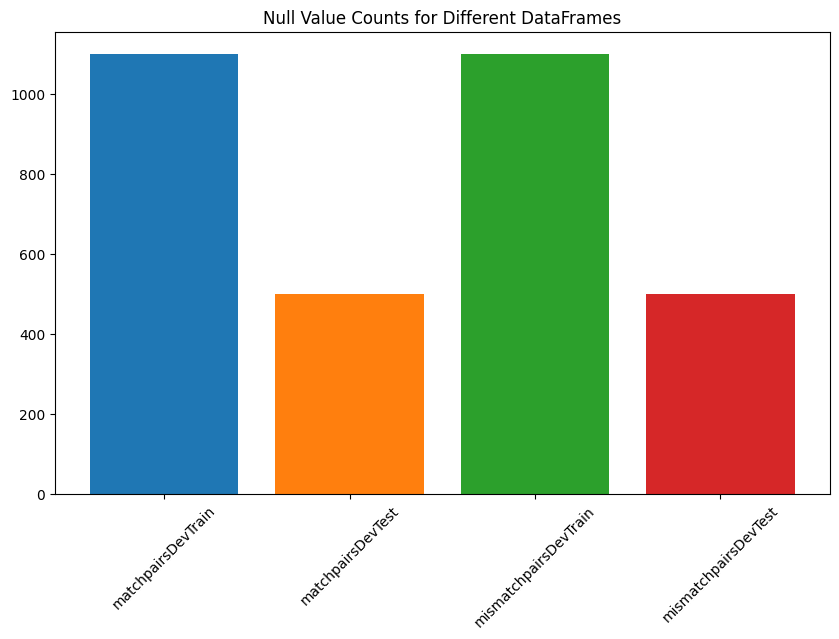

In [57]:
# Missing values check by visualization
plt.figure(figsize=(10, 6))
plt.bar('matchpairsDevTrain', matchpairsDevTrain.isnull().count())
plt.bar('matchpairsDevTest', matchpairsDevTest.isnull().count())
plt.bar('mismatchpairsDevTrain', mismatchpairsDevTrain.isnull().count())
plt.bar('mismatchpairsDevTest', mismatchpairsDevTest.isnull().count())
plt.xticks(rotation=45)
plt.title('Null Value Counts for Different DataFrames')

No missing values !

In [151]:
import PIL.Image
from torchvision import transforms
import random

In [152]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [153]:
# Function to load and preprocess an image
def load_image(img_path):
    img = Image.open(img_path)
    img = img.convert('RGB')  # Convert to RGB if the image has other color modes
    img = transform(img)
    return img

In [154]:
!wget -O test_img.jpg "https://images.unsplash.com/photo-1542909168-82c3e7fdca5c?q=80&w=1000&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8OHx8ZmFjZXxlbnwwfHwwfHx8MA%3D%3D"

--2024-04-01 14:16:30--  https://images.unsplash.com/photo-1542909168-82c3e7fdca5c?q=80&w=1000&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8OHx8ZmFjZXxlbnwwfHwwfHx8MA%3D%3D
Resolving images.unsplash.com (images.unsplash.com)... 151.101.2.208, 151.101.66.208, 151.101.130.208, ...
Connecting to images.unsplash.com (images.unsplash.com)|151.101.2.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85280 (83K) [image/jpeg]
Saving to: 'test_img.jpg'

test_img.jpg        100%[===================>]  83.28K  --.-KB/s    in 0.01s   

2024-04-01 14:16:30 (7.29 MB/s) - 'test_img.jpg' saved [85280/85280]



In [155]:
load_image("test_img.jpg")

tensor([[[ 0.3481,  0.3481,  0.3652,  ..., -0.9877, -0.9877, -0.9877],
         [ 0.3652,  0.3652,  0.3652,  ..., -0.9705, -0.9877, -0.9877],
         [ 0.3652,  0.3823,  0.3652,  ..., -0.9705, -0.9877, -0.9877],
         ...,
         [-0.4739, -0.4739, -0.4568,  ..., -1.2617, -1.2788, -1.2788],
         [-0.4739, -0.4911, -0.4739,  ..., -1.2788, -1.2788, -1.2959],
         [-0.4911, -0.5082, -0.4911,  ..., -1.2959, -1.2959, -1.2959]],

        [[ 0.5203,  0.5203,  0.5378,  ..., -0.8803, -0.8803, -0.8803],
         [ 0.5378,  0.5378,  0.5378,  ..., -0.8627, -0.8803, -0.8803],
         [ 0.5378,  0.5553,  0.5378,  ..., -0.8627, -0.8803, -0.8803],
         ...,
         [-0.3375, -0.3375, -0.3200,  ..., -1.1253, -1.1429, -1.1429],
         [-0.3550, -0.3725, -0.3550,  ..., -1.1429, -1.1429, -1.1604],
         [-0.3725, -0.3901, -0.3725,  ..., -1.1604, -1.1604, -1.1604]],

        [[ 0.7228,  0.7228,  0.7402,  ..., -0.6890, -0.6890, -0.6890],
         [ 0.7402,  0.7402,  0.7402,  ..., -0

In [175]:
def visualize_image(image_tensor):
    image_tensor = image_tensor.transpose((1, 2, 0))     # Transpose the dimensions to (height, width, channels)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image_tensor = (image_tensor * std) + mean
    image_tensor = np.clip(image_tensor, 0, 1)
    plt.imshow(image_tensor)     # Plot the image
    plt.axis('off')
    plt.show()

In [176]:
# Test the load_image function
load_image("test_img.jpg")

tensor([[[ 0.3481,  0.3481,  0.3652,  ..., -0.9877, -0.9877, -0.9877],
         [ 0.3652,  0.3652,  0.3652,  ..., -0.9705, -0.9877, -0.9877],
         [ 0.3652,  0.3823,  0.3652,  ..., -0.9705, -0.9877, -0.9877],
         ...,
         [-0.4739, -0.4739, -0.4568,  ..., -1.2617, -1.2788, -1.2788],
         [-0.4739, -0.4911, -0.4739,  ..., -1.2788, -1.2788, -1.2959],
         [-0.4911, -0.5082, -0.4911,  ..., -1.2959, -1.2959, -1.2959]],

        [[ 0.5203,  0.5203,  0.5378,  ..., -0.8803, -0.8803, -0.8803],
         [ 0.5378,  0.5378,  0.5378,  ..., -0.8627, -0.8803, -0.8803],
         [ 0.5378,  0.5553,  0.5378,  ..., -0.8627, -0.8803, -0.8803],
         ...,
         [-0.3375, -0.3375, -0.3200,  ..., -1.1253, -1.1429, -1.1429],
         [-0.3550, -0.3725, -0.3550,  ..., -1.1429, -1.1429, -1.1604],
         [-0.3725, -0.3901, -0.3725,  ..., -1.1604, -1.1604, -1.1604]],

        [[ 0.7228,  0.7228,  0.7402,  ..., -0.6890, -0.6890, -0.6890],
         [ 0.7402,  0.7402,  0.7402,  ..., -0

In [178]:
# Function to create pairs of images and labels
def create_pairs(df, is_match):
    pairs = []
    labels = []
    for _, row in df.iterrows():
        # Get the name and image numbers for the first image
        name1 = row['name']
        imagenum1 = row['imagenum1']
        # Get the name and image numbers for the second image
        if is_match:
            # For matched pairs, both images are of the same person
            name2 = name1
            imagenum2 = row['imagenum2']
            label = 1
        else:
            # For mismatched pairs, the images are of different people
            name2 = row['name.1'] if 'name.1' in df.columns else row['name']
            imagenum2 = row['imagenum2']
            label = 0
        # Load images
        img1_path = f"../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/{name1}/{name1}_{imagenum1:04d}.jpg"
        img2_path = f"../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/{name2}/{name2}_{imagenum2:04d}.jpg"
        img1 = load_image(img1_path)
        img2 = load_image(img2_path)
        # Append the pair and label to the respective lists
        pairs.append([img1, img2])
        labels.append(label)

    # Convert the lists to NumPy arrays
    pairs = np.array(pairs)
    labels = np.array(labels)

    return pairs, labels.astype("float32")

In [179]:
train_matched_pairs, train_matched_labels = create_pairs(matchpairsDevTrain, is_match=True)
train_mismatched_pairs, train_mismatched_labels = create_pairs(mismatchpairsDevTrain, is_match=False)
test_matched_pairs, test_matched_labels = create_pairs(matchpairsDevTest, is_match=True)
test_mismatched_pairs, test_mismatched_labels = create_pairs(mismatchpairsDevTest, is_match=False)

train_pairs = np.concatenate((train_matched_pairs, train_mismatched_pairs), axis=0)
train_labels = np.concatenate((train_matched_labels, train_mismatched_labels), axis=0)
test_pairs = np.concatenate((test_matched_pairs, test_mismatched_pairs), axis=0)
test_labels = np.concatenate((test_matched_labels, test_mismatched_labels), axis=0)

# Shuffle the training data
indices = np.arange(len(train_pairs))
random.shuffle(indices)
train_pairs = train_pairs[indices]
train_labels = train_labels[indices]

# Shuffle the test set
indices = np.arange(len(test_pairs))
random.shuffle(indices)
test_pairs = test_pairs[indices]
test_labels = test_labels[indices]

Text(0.5, 0.98, 'Example of matching pairs')

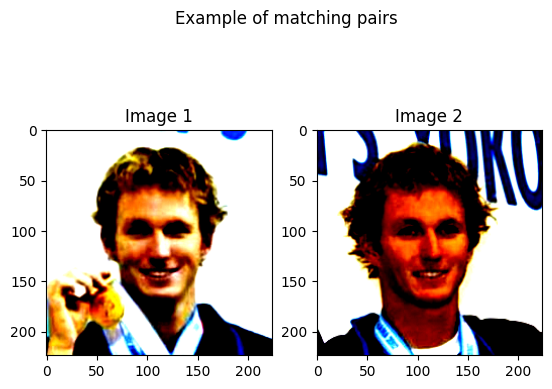

In [189]:
img1, img2 = train_matched_pairs[0]
img1, img2 = img1.transpose((1, 2, 0)), img2.transpose((1, 2, 0))
# Display matching pairs
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title('Image 1')
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title('Image 2')
plt.suptitle('Example of matching pairs')

Text(0.5, 0.98, 'Example of mismatching pairs')

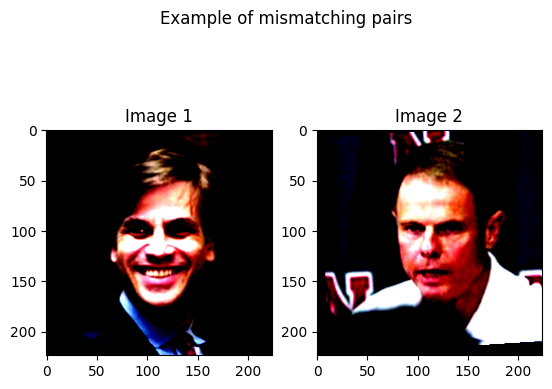

In [190]:
img1, img2 = train_mismatched_pairs[1]
img1, img2 = img1.transpose((1, 2, 0)), img2.transpose((1, 2, 0))

# Display mismatching pairs
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title('Image 1')
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title('Image 2')
plt.suptitle('Example of mismatching pairs')

Label: 0.0


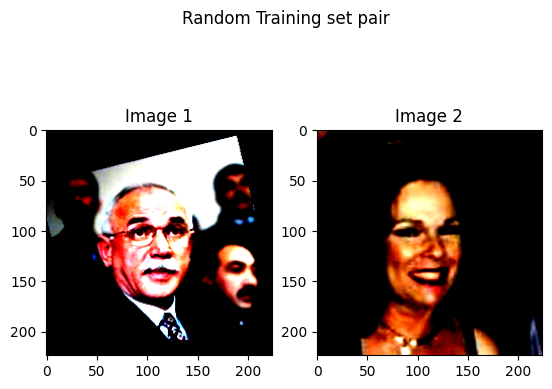

In [192]:
img1, img2 = train_pairs[0, :, :, :]
img1, img2 = img1.transpose((1, 2, 0)), img2.transpose((1, 2, 0))

plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title('Image 1')
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title('Image 2')
plt.suptitle("Random Training set pair")

print(f"Label:", train_labels[0])

### Model Building

In [78]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

Here's how you can have an idea about the model's architecture:

In [79]:
# Load the VGG16 model with pre-trained weights on ImageNet
vgg16_model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

In [80]:
vgg16_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

As we said earlier we don't want to include these fully connected layers in other words we have to set the include_top to False

In [111]:
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

You see! Now we'll make the layers up to block 4 to be non-trainable to get advantage of what has been already learned from the pretrained VGG16.

In [112]:
len(vgg16_model.layers)

19

In this case we'll freeze the first 15 layers.

In [113]:
for layer in vgg16_model.layers:
    layer.trainable = False

In [114]:
vgg16_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [119]:
# Define the input layers for the Siamese network
input_1 = Input(shape=(224, 224, 3))
input_2 = Input(shape=(224, 224, 3))
# Get the resulting features
encoded_1 = vgg16_model(input_1)
encoded_2 = vgg16_model(input_2)
# Flatten the feature maps
x1 = Flatten()(encoded_1) 
x2 = Flatten()(encoded_2)
# Adding the fully connected layers: The output is the resulting encoding or embeddings we wanted to have
fc_1 = Dense(512, activation='relu')(x1) 
fc_2 = Dense(512, activation='relu')(x2)

In [127]:
from keras import ops
def euclidean_distance(vects):
    x, y = vects
    sum_square = ops.sum(ops.square(x - y), axis=1, keepdims=True)
    return ops.sqrt(ops.maximum(sum_square, tf.keras.backend.epsilon()))

In [128]:
# Compute the similarity score
merge_layer = merge_layer = tf.keras.layers.Lambda(euclidean_distance, output_shape=(1,))([fc_1, fc_2])
output_layer = Dense(1, activation='sigmoid')(merge_layer)
# Define the Siamese model
siamese_model = Model(inputs=[input_1, input_2], outputs=output_layer)
siamese_model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_18      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ input_layer_17[0… │
│                     │                   │            │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_12          │ (None, 25088)     │          0 │ vgg16[4][0]       │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_13          │ (None, 25088)     │          0 │ vgg16[5][0]       │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 512)       │ 12,845,568 │ flatten_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 512)       │ 12,845,568 │ flatten_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 1)         │          0 │ dense_16[0][0],   │
│                     │                   │            │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 1)         │          2 │ lambda_5[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 40,405,826 (154.14 MB)

 Trainable params: 25,691,138 (98.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

#### Contructive Loss: A Comprehensive Guide
The constructive loss is a specific loss function for the face verification tasks, what it does is motivate the model to minimize the distance between similar (positive) pairs of inputs while maximizing the distance between dissimilar (negative) pairs.

The contrastive loss for a pair of inputs (x1, x2) and their similarity label Y can be formulated as:

$L(x_1, x_2, Y) = (1 - Y) \times D^2 + Y \times \max(0, m - D)^2$

Where:
- D = distance between the feature vectors of x1 and x2 

- Y = 0 if x1 and x2 are dissimilar (negative pair), 1 if they are similar (positive pair)

- m = margin value, enforcing a minimum distance between negative pairs

We'll use for our case the binary crossentropy.

In [129]:
def loss(margin=1):
    def contrastive_loss(y_true, y_pred):
        square_pred = ops.square(y_pred)
        margin_square = ops.square(ops.maximum(margin - (y_pred), 0))
        return ops.mean((1 - y_true) * square_pred + (y_true) * margin_square)

    return contrastive_loss

In [130]:
margin = 1
siamese_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), metrics=["accuracy"])

In [131]:
# Hyperparameters
batch_size = 32
epochs = 12
history = siamese_model.fit([train_pairs[:, 0, :, :], train_pairs[:, 1, :, :]], train_labels, batch_size=batch_size, epochs=epochs)

Epoch 1/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 0.4769 - loss: 272.8263
Epoch 2/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.4919 - loss: 1.0743
Epoch 3/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.4944 - loss: 0.7690
Epoch 4/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.5014 - loss: 0.8049
Epoch 5/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.4996 - loss: 0.6940
Epoch 6/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.5028 - loss: 0.6938
Epoch 7/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.4979 - loss: 2.4711
Epoch 8/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.5142 - loss: 2.0251
Epoch 9/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.4912 - loss: 0.6955
Epoch 10/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.4805 - loss: 1.6875
Epoch 11/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.5113 - loss: 0.6938
Epoch 12/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/s

In [132]:
results = siamese_model.evaluate([test_pairs[:, 0, :, :], test_pairs[:, 1, :, :]], test_labels)
print("test loss, test acc:", results)

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.5299 - loss: 70.4424
test loss, test acc: [77.59884643554688, 0.5]


1.0


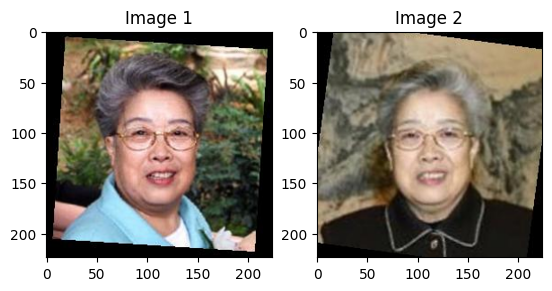

In [102]:
img1, img2 = train_pairs[100, 0, :, :], train_pairs[100, 1, :, :]

plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title('Image 1')
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title('Image 2')

print(train_labels[100])

In [103]:
img1, img2 = train_pairs[100, 0, :, :].reshape(1, 224, 224, 3), train_pairs[100, 1, :, :].reshape(1, 224, 224, 3)
siamese_model.predict([img1, img2])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


array([[0.]], dtype=float32)